In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import platform

In [3]:
#데이터
df = pd.read_csv("TGDT_per_movie_data.csv")

In [4]:
df['showTm'].describe()

count    2452.000000
mean      107.107259
std        22.132246
min        40.000000
25%        93.000000
50%       106.000000
75%       119.000000
max       263.000000
Name: showTm, dtype: float64

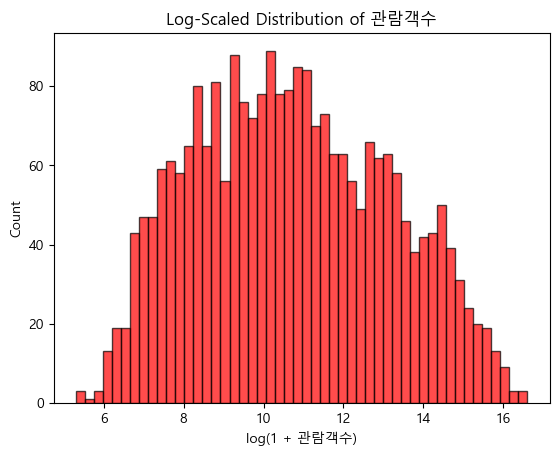

In [6]:
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


plt.hist(np.log1p(df['누적관람객수']), bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title("Log-Scaled Distribution of 관람객수")
plt.xlabel("log(1 + 관람객수)")
plt.ylabel("Count")
plt.show()

In [7]:
# 1-1. 관람객 수, 날짜 결측 제거
df = df.dropna(subset=['누적관람객수', 'openDt', 'targetDt'])

# 1-2. 날짜 파싱
df['openDt'] = pd.to_datetime(df['openDt'], format='%Y%m%d', errors='coerce')
df['targetDt'] = pd.to_datetime(df['targetDt'], format='%Y%m%d', errors='coerce')
df = df.dropna(subset=['openDt', 'targetDt'])

# 1-3. 관람객 수 이상치 제거
df = df[df['누적관람객수'] >= 1000]  # 너무 적은 영화 제외

In [8]:
import numpy as np

In [9]:
# 로그 변환 대상
log_features = ['누적관람객수', 'salesAmt', 'salesAcc', 'audiAcc', 'showCnt', 'scrnCnt']

# 각 피처에 대해 로그 변환 후
for col in log_features:
    if col in df.columns:
        df[f'log_{col}'] = np.log1p(df[col])

In [ ]:
# 불필요한 컬럼 제거
drop_cols = [
    'Unnamed: 0', 'movieNm_box',
    'rank', 'rankInten', 'rankOldAndNew',
    'productionCompanies', 'prdtStatNm', 'typeNm'
]

In [11]:
# 불필요한 컬럼 실제 제거
df = df.drop(columns=[col for col in drop_cols if col in df.columns])


In [ ]:
# 저장
df.to_csv("TGDT_per_movie_data_cleaned.csv", index=False, encoding='utf-8-sig')

### 정제 완료 후 데이터로 EDA ###

In [11]:
df = pd.read_csv("TGDT_per_movie_data_cleaned.csv")

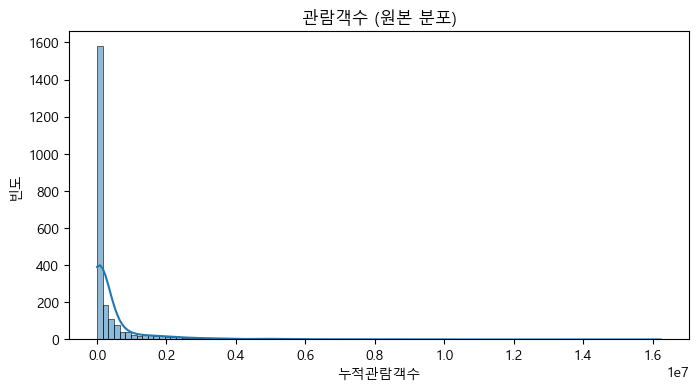

In [12]:
# 일반 분포
plt.figure(figsize=(8, 4))
sns.histplot(df['누적관람객수'], bins=100, kde=True)
plt.title("관람객수 (원본 분포)")
plt.xlabel("누적관람객수")
plt.ylabel("빈도")
plt.show()

# 로그 분포
plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(df['누적관람객수']), bins=100, kde=True)
plt.title("관람객수 (log1p 분포)")
plt.xlabel("log(1 + 누적관람객수)")
plt.ylabel("빈도")
plt.show()

타깃 변수는 log_누적관람객수 사용 권장될 것으로 보임.

In [13]:
log_target = 'log_누적관람객수'

# 주요 수치형 피처
numeric_features = [
    'salesAmt', 'salesAcc', 'audiAcc', 'showCnt', 'scrnCnt', 'showTm'
]

# 날짜 변환 및 days_since_open 생성
df['openDt'] = pd.to_datetime(df['openDt'], errors='coerce')
df['targetDt'] = pd.to_datetime(df['targetDt'], errors='coerce')
df['days_since_open'] = (df['targetDt'] - df['openDt']).dt.days

# 'days_since_open' 컬럼이 정상적으로 생성됐으면 추가 분석에 포함
if 'days_since_open' in df.columns:
    numeric_features.append('days_since_open')

# 실제 상관관계 계산을 위한 사용 가능한 컬럼 필터링
available_features = [col for col in numeric_features if col in df.columns and df[col].notnull().all()]

# 상관계수 계산
correlations = df[available_features + [log_target]].corr()[log_target].sort_values(ascending=False)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title(f"{log_target}와의 상관관계")
plt.xlabel("상관계수")
plt.ylabel("피처")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\김지웅\AppData\Local\Temp\ipykernel_18256\3999855066.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


### 파생변수 생성

In [ ]:
import numpy as np

# 0으로 나눌 경우 방지용 대체 컬럼 생성
df['scrnCnt_safe'] = df['scrnCnt'].replace(0, np.nan)
df['showCnt_safe'] = df['showCnt'].replace(0, np.nan)

# salesAmt 파생 피처
# 1. 스크린당 매출: 한 스크린에서 평균적으로 발생한 매출
df['sales_per_screen'] = df['salesAmt'] / df['scrnCnt_safe']

# 2. 상영 회차당 매출: 한 번 상영할 때 평균적으로 발생한 매출
df['sales_per_show'] = df['salesAmt'] / df['showCnt_safe']

# 3. 1회 상영당 배정된 스크린 수: 회차 대비 스크린 수로, 상영 밀도 또는 배급 강도 지표
df['screen_per_show'] = df['scrnCnt_safe'] / df['showCnt_safe']

# 임시 컬럼 제거
df = df.drop(columns=['scrnCnt_safe', 'showCnt_safe'])


In [ ]:
# 상영시간 기반 파생 피처 생성
# 1. 단편 영화 여부: 상영 시간이 60분 미만인 경우
df['is_short_film'] = (df['showTm'] < 60).astype(int)
# 2. 장편 영화 여부: 상영 시간이 180분 초과인 경우
df['is_long_film'] = (df['showTm'] > 180).astype(int)

In [21]:
df.to_csv("TGDT_per_movie_data_cleaned_plus_feature.csv", index=False, encoding='utf-8-sig')

### 다중공선성 진단 (VIF 분석)

In [9]:
df = pd.read_csv("TGDT_per_movie_data_cleaned_plus_feature.csv")

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 수치형 피처 중 사용할 피처만 선택
vif_features = [
    'log_showCnt', 'log_scrnCnt', 
    'sales_per_screen', 'sales_per_show', 'screen_per_show', 
    'showTm'
]

# 상수항 추가
X_vif = add_constant(df[vif_features].dropna())

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
vif_data


feature         VIF
0             const  496.369703
1       log_showCnt  350.062439
2       log_scrnCnt  269.209963
3   screen_per_show   21.422957
4    sales_per_show    3.884007
5  sales_per_screen    3.492654
6            showTm    1.032812

### 배우/감독/장르 임베딩 전 간단 EDA

In [ ]:
# 문자열 → 리스트로 변환 (| 기준)
df['directors'] = df['directors'].fillna('').apply(lambda x: x.split('|') if x else [])
df['actors'] = df['actors'].fillna('').apply(lambda x: x.split('|') if x else [])
df['genres'] = df['genres'].fillna('').apply(lambda x: x.split('|') if x else [])

# 기초 통계 추출 함수
def get_basic_stats(column_name):
    exploded = df[[column_name, 'log_누적관람객수']].explode(column_name)
    grouped = exploded.groupby(column_name)['log_누적관람객수'].agg(['count', 'mean']).sort_values(by='count', ascending=False)
    grouped.columns = ['등장횟수', '평균_log_관객수']
    return grouped

# 각각 통계 생성
director_stats = get_basic_stats('directors')
actor_stats = get_basic_stats('actors')
genre_stats = get_basic_stats('genres')



AttributeError: 'list' object has no attribute 'split'

In [ ]:
print("감독 통계")
display(director_stats.head(30))

In [ ]:
print("\n배우 통계")
print(actor_stats.head(10))

In [ ]:
print("\n장르 통계")
print(genre_stats.head(10))

### 주요 감독/배우/장르를 통계를 통해 기준 만들기

In [48]:
# 주요 요소 기준 정의
main_directors = director_stats[
    (director_stats['등장횟수'] >= 5) & (director_stats['평균_log_관객수'] >= 11)
].index.tolist()

main_actors = actor_stats[
    (actor_stats['등장횟수'] >= 5) & (director_stats['평균_log_관객수'] >= 10)
].index.tolist()

main_genres = genre_stats[
    (genre_stats['등장횟수'] >= 100) & (genre_stats['평균_log_관객수'] >= 11)
].index.tolist()

C:\Users\김지웅\AppData\Local\Temp\ipykernel_29720\2956014011.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  main_actors = actor_stats[


In [25]:
# 결과 출력 (상위 10개만 예시)
display("주요 감독 (Top 10):", main_directors[:10])

'주요 감독 (Top 10):'

['유야마 쿠니히코',
 '리들리 스콧',
 '소토자키 하루오',
 '가이 리치',
 '데이빗 레이치',
 '스티븐 스필버그',
 '고레에다 히로카즈',
 '채드 스타헬스키',
 '제임스 카메론',
 '우민호']

In [49]:
display("주요 배우 (Top 10):", main_actors[:10])

'주요 배우 (Top 10):'

['하정우', '정우성', '이병헌', '김윤석', '김의성', '패트릭 윌슨', '브래들리 쿠퍼', '정진영', '이주영', '이정재']

In [39]:
display("주요 장르:", main_genres)

'주요 장르:'

['액션', '스릴러', '코미디', '어드벤처', '범죄', 'SF', '미스터리']

In [31]:
# 주요 요소 포함 여부 함수
def has_main_item(item_list, main_set):
    return int(bool(set(item_list) & main_set))

# 파생 피처 생성
df['has_main_director'] = df['directors'].apply(lambda x: has_main_item(x, set(main_directors)))
df['has_main_actor'] = df['actors'].apply(lambda x: has_main_item(x, set(main_actors)))
df['has_main_genre'] = df['genres'].apply(lambda x: has_main_item(x, set(main_genres)))

# 결과 확인
display(df[['has_main_director', 'has_main_actor', 'has_main_genre']].head())

has_main_director  has_main_actor  has_main_genre
0                  0               0               1
1                  0               1               1
2                  0               0               0
3                  0               1               1
4                  0               0               0

In [30]:
df.to_csv("TGDT_per_movie_data_cleaned_plus_feature.csv", index=False, encoding='utf-8-sig')